# **Neural Networks Demystified [Part 2]**

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


- For more information, check out [Nueral Networks Demystified Parts 5-7](https://www.youtube.com/watch?v=pHMzNW8Agq4).

In [2]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

#Normalize Data
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

- Last time, we dug deep into **backpropogation**.
- Here's our backpropogation algorithm algorithm, wrapped up into our python class. 
- We've also added methods for getting and setting parameters.

In [3]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

![](../graphics/spacer_small.png)

## Let's make sure the big picture makes sense here.

![](../graphics/NNQ9-01.png)

---

Let's try it!

In [4]:
NN = Neural_Network()
cost1 = NN.costFunction(X, y)
dJdW1, dJdW2 = NN.costFunctionPrime(X,y)

learning_rate = 0.1
NN.W1 = NN.W1 + learning_rate*dJdW1
NN.W2 = NN.W2 + learning_rate*dJdW2
cost2 = NN.costFunction(X,y)
print(cost1, cost2, cost2>cost1)

0.09331464501423224 0.09494198572754622 True


![](../graphics/spacer_small.png)

![](../graphics/NNQ10-01.png)

---

![](../graphics/spacer_small.png)

In [5]:
NN = Neural_Network()
cost1 = NN.costFunction(X, y)
dJdW1, dJdW2 = NN.costFunctionPrime(X,y)

learning_rate = 0.1
NN.W1 = NN.W1 - learning_rate*dJdW1
NN.W2 = NN.W2 - learning_rate*dJdW2
cost2 = NN.costFunction(X,y)
print(cost1, cost2, cost2>cost1)

0.7423103424518204 0.7199469038943875 False


## **This is the heart of gradient descent.**

- Taking small steps "downhill", we can find a solution in the 9-dimensional weight space of our function.
- Now, as you may know, implementing gradient descent is a bit complex, so we'll use the scipy optimization package

In [6]:
from scipy import optimize

- We'll also use a special class to train our network:

In [7]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res
    

In [8]:
#Setup network, set random weights:
NN = Neural_Network()

#Intantiate Trainer class:
T = trainer(NN)

#Train network!
T.train(X,y)

         Current function value: 0.007200
         Iterations: 200
         Function evaluations: 219
         Gradient evaluations: 219


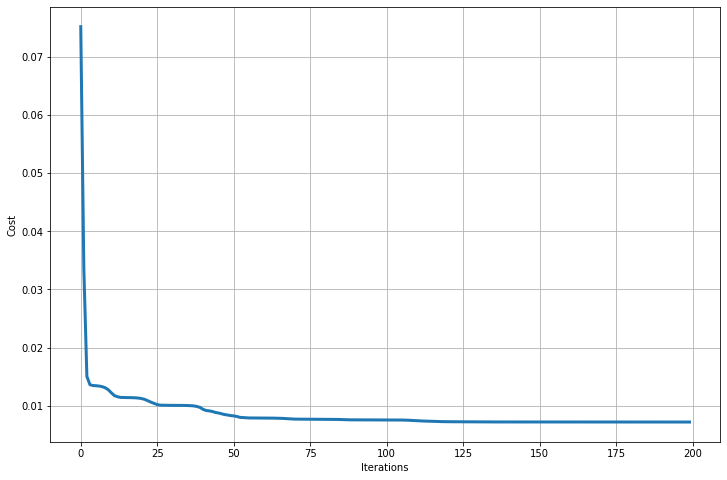

In [9]:
fig = figure(0, (12, 8))
plot(T.J, linewidth = 3)
grid(1)
xlabel('Iterations')
ylabel('Cost');

- This type of plot is perhaps the most important visual to pay attention to when training neural networks.

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

# **Now that we've trained our weights, what should be true about the value of our gradients?**

![](../graphics/spacer_small.png)

In [10]:
# NN.computeGradients(X, y)

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

### Now that we have some trained weights, we can see how they perform across a range of inputs:

In [11]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

In [12]:
allOutputs = NN.forward(allInputs)

In [13]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
#Allows us to rotate a 3d plot in the notebook. Might have to run twice for some dumb reason
#%pylab qt
#%pylab inline

Text(0.5, 0, 'Test Score')

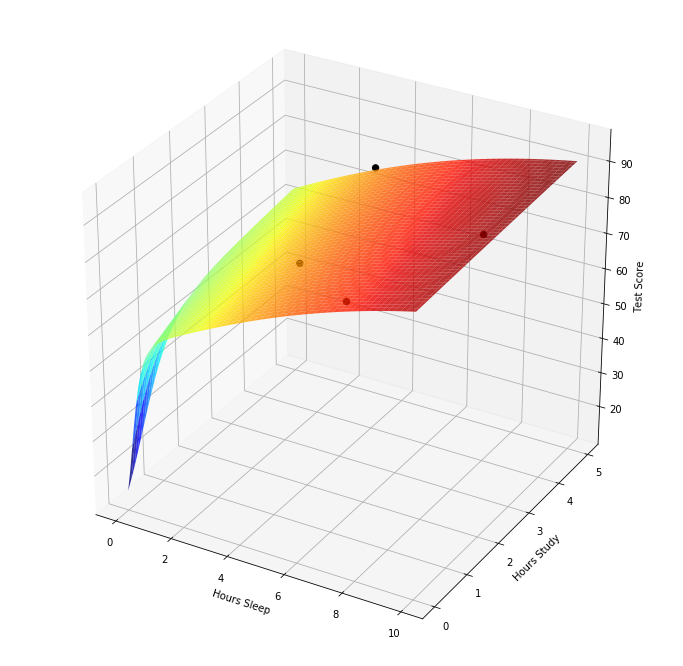

In [21]:
fig = plt.figure(0, (12,12))
ax = fig.gca(projection='3d')

#Scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=40)

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.8)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

In [20]:
#Switch back to inline mode.
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


## Overfitting and Regularization
- As you've alreay seen in the video, we haven't done anything to mitigate overfitting
- As you may already know, this is a **big deal**.
- First, let's look for evidence of overfitting. 
- As we saw in the Learning to See module, one way to do this is to measure performance on a held out test set.
- Let's introduce some test data.

In [22]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
maxValues = np.amax(trainX, axis=0)
trainX = trainX/maxValues
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/maxValues
testY = testY/100 #Max test score is 100

## Modify trainer class a bit to check testing error during training

In [23]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res


In [24]:
#Train network with new data:
NN = Neural_Network()

T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 154
         Function evaluations: 163
         Gradient evaluations: 163


Populating the interactive namespace from numpy and matplotlib


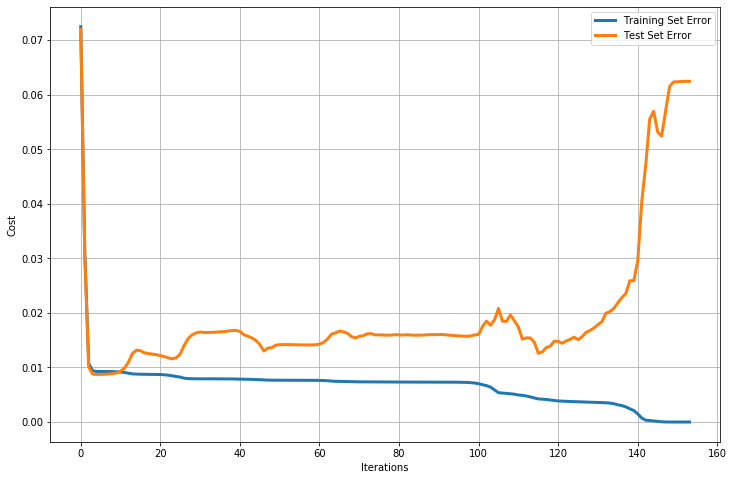

In [25]:
%pylab inline
#Plot cost during training:
fig = figure(0, (12, 8))
plot(T.J, linewidth = 3)
plot(T.testJ, linewidth = 3)
grid(1)
xlabel('Iterations')
ylabel('Cost');
legend(['Training Set Error', 'Test Set Error'])

- This graph has alot to tell us! 
- Are we overfitting?
- How do you know?
- Where does overfitting start?
- Why does test set error go down and then back up?

![](../graphics/spacer_small.png)

## Regularization

- There's lots of interesting ways to *regularize* neural networks, check out [Chapter 7 of Goodfellow Deep Learning](https://www.deeplearningbook.org/contents/regularization.html). 
- Here's we'll use a simple technique called **weight decay** also known as as $L^2$ Parameter Norm Penalty.
- To implement this technique, we need to add the square of our weights to our cost function:

![](../graphics/spacer_small.png)

$$
J = \sum \frac{1}{2}(y-\hat{y})^2 + \frac{\lambda}{2} \bigg(\sum (W^{(1)})^2 + \sum (W^{(2)})^2 \bigg)
$$

- Let's make sure this equation makes sense.
- What is the dimension of the second term?
- What do you think $\lambda$ does?
- What do you think the **effect is of adding this term to our cost function?**

---

![](../graphics/spacer_small.png)

- We need to make one more minor modification to our cost. $\lambda$ is supposed to control the relative weighting between our 2 cost terms - allowing us to control how much regularization we apply. However, our first term depends heavily on how many training examples we use. We can fix this by dividing the first term in our cost function by our total number of examples, let's call this $m$:

$$
J = \frac{1}{m}\sum \frac{1}{2}(y-\hat{y})^2 + \frac{\lambda}{2} \bigg(\sum (W^{(1)})^2 + \sum (W^{(2)})^2 \bigg)
$$

![](../graphics/spacer_small.png)

---

- Now, we're almost there, just one more loose end to tie up. 
- Since we've changed our cost function, this means that our super important cost function gradients, $\frac{\partial J}{\partial W^{(2)}}$ and $\frac{\partial J}{\partial W^{(1)}}$ that guide our gradient descent will change. 
- Fortunately, thanks to the [sum rule in differentiation](https://en.wikipedia.org/wiki/Sum_rule_in_differentiation), we can just compute the gradient of our new cost function term and add it to our existing gradients.

![](../graphics/NNQ11-01.png)

---

![](../graphics/NNQ12-01.png)

---

- Now, let's make these additions to our Neural Network class.

In [26]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

## And Train with Regularization!

In [27]:
NN = Neural_Network(Lambda=0.0001)

T = trainer(NN)
T.train(X,y,testX,testY)

Optimization terminated successfully.
         Current function value: 0.002729
         Iterations: 79
         Function evaluations: 83
         Gradient evaluations: 83


Text(0, 0.5, 'Cost')

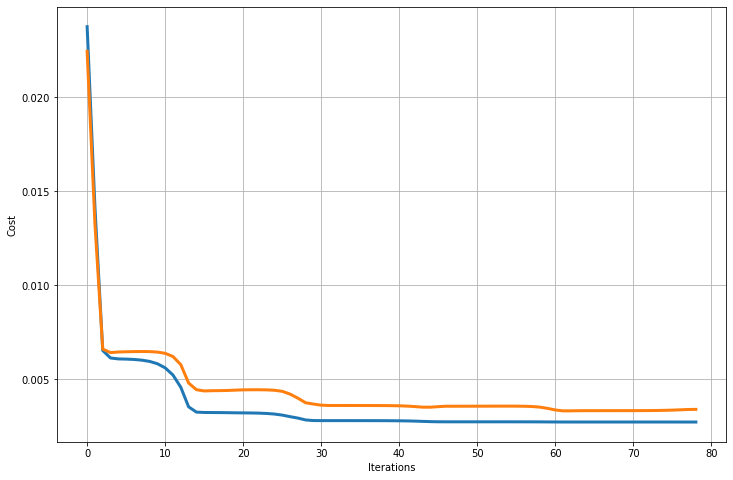

In [28]:
fig = figure(0, (12, 8))
plot(T.J, linewidth = 3)
plot(T.testJ, linewidth = 3)
grid(1)
xlabel('Iterations')
ylabel('Cost')

1. Are we still overfitting?
2. If so, are we overfitting more or less than before?

---

Let's visualize our prediction across our various inputs again.

In [29]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
#Allows us to rotate a 3d plot in the notebook. Might have to run twice for some dumb reason
#%pylab notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'Test Score')

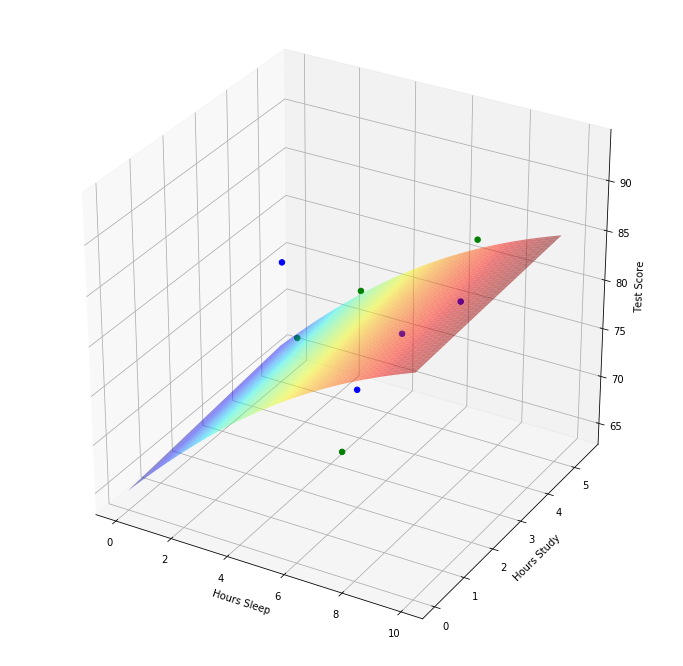

In [31]:
allOutputs = NN.forward(allInputs)

fig = plt.figure(0, (12,12))

ax = fig.gca(projection='3d')

ax.scatter(10*trainX[:,0], 5*trainX[:,1], 100*trainY, c='g', alpha = 1, s=30)
ax.scatter(10*testX[:,0], 5*testX[:,1], 100*testY, c='b', alpha = 1, s=30)

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

# **The End**

## Appendix

$$
\frac{\partial \frac{\lambda}{2} \bigg(\sum (W^{(1)})^2 + \sum (W^{(2)})^2 \bigg)}{ \partial W^{(2)}} = 
$$

$$
\lambda \sum (W^{(2)})
$$

$$
\lambda W^{(2)}
$$

$$
\lambda \big( W^{(2)} \big) ^T
$$

$$
\lambda \big( \sum (W^{(1)})  + \sum (W^{(2)}) \big)
$$